# loading data

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

# plotting and visualization

import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score,cross_validate
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

import pickle

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

import os

In [3]:
X_train = pd.read_csv("../Capstone_Two_Project/data/processed/X_train.csv", index_col = 0)

In [4]:
X_test = pd.read_csv("../Capstone_Two_Project/data/processed/X_test.csv", index_col = 0)

In [5]:
y_train = pd.read_csv("../Capstone_Two_Project/data/processed/y_train.csv",index_col = False)

y_train=y_train.drop('Unnamed: 0',axis=1)

In [6]:
y_test = pd.read_csv("../Capstone_Two_Project/data/processed/y_test.csv", index_col = False)
y_test=y_test.drop('Unnamed: 0',axis=1)

# Modeling

## Metrics for model performance

For a classification machine learning, several metrics such as accuracy, recall, F1 and ROC_AUC are used in model performance evaluation. The project purpose is to predict good quality wine, and the dataset is imblanced, therefore the model with highest precision values with relative high accuracy among the three models:Logisticregression, randomforest, XGBoost will be the winner. 

## Baseline model

dummyclassifier is used in modeling prediction. it will serve as the baseline modeling, good models should shows better metris than it.

In [7]:
dummy = DummyClassifier(strategy ="stratified",random_state = 123)
dummy.fit(X_train.values,y_train.values.ravel())
y_pred = dummy.predict(X_test.values)
y_pred_probs = dummy.predict_proba(X_test.values) [:,1]

In [8]:
pc_dummy = precision_score(y_test, y_pred,average='weighted')
report_dummy = classification_report(y_test, y_pred)
cm_dummy = confusion_matrix(y_test, y_pred)
print('dummy: precision=%.3f' % (pc_dummy))

dummy: precision=0.697


In [9]:
print("report:", report_dummy,"\n")

report:               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1293
           1       0.20      0.21      0.21       303

    accuracy                           0.69      1596
   macro avg       0.51      0.51      0.51      1596
weighted avg       0.70      0.69      0.70      1596
 



In dummy model, the precison for predict good win is 0.20. overall precision is 0.697.

three models:logisticregression, random forest and XGBoost Model will be selected. Through compare the cross validtion scores, the final model will be select and final tuned. Also, the number of features used in modeling was controlled bu selectkbest algorithms. 

## Logisticregression model

### make a pipeline

In [10]:
from sklearn.pipeline import Pipeline
pipe_log = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression)),("model",
    LogisticRegression())]
)

In [11]:
pipe_log.fit(X_train.values, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x0000023261644790>)),
                ('model', LogisticRegression())])

In [12]:
y_tr_pred_log = pipe_log.predict(X_train.values)
y_te_pred_log= pipe_log.predict(X_test.values)

In [13]:
y_pred_log_probs = pipe_log.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_log_probs))

0.8186375482095772


In [14]:
precision_score(y_train, y_tr_pred_log, average = "weighted" ), precision_score(y_test, y_te_pred_log, average ="weighted")

(0.8000529589031776, 0.793249271385863)

In [15]:
accuracy_score(y_train, y_tr_pred_log), accuracy_score(y_test, y_te_pred_log)

(0.8267991407089151, 0.8226817042606517)

In [16]:
# report_log = classification_report(y_test, y_te_pred_log)
# cm_log = confusion_matrix(y_test, y_te_pred_log)
# ConfusionMatrixDisplay(confusion_matrix=cm_log,display_labels=pipe_log.classes_).plot()
# plt.show()
print(classification_report(y_test, y_te_pred_log))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1293
           1       0.58      0.24      0.34       303

    accuracy                           0.82      1596
   macro avg       0.71      0.60      0.62      1596
weighted avg       0.79      0.82      0.79      1596



### Assessing performance using cross-validation

In [17]:
cv_results_log = cross_validate(pipe_log, X_train, y_train.values.ravel(), cv=5,scoring = "precision")

In [18]:
cv_scores_log = cv_results_log['test_score']
cv_scores_log

array([0.64912281, 0.58181818, 0.58064516, 0.5862069 , 0.56140351])

In [19]:
cv_scores_mean_log = np.mean(cv_scores_log)
cv_score_std_log = np.std(cv_scores_log)
print(cv_scores_mean_log, cv_score_std_log)

0.5918393110899405 0.029883751717535986


the cv score is only 0.59, which is lower than the intial logistic regression modeling. 

## Random forest 

### using the default setting

In [20]:
pipe_rf = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression)),("rf",
    RandomForestClassifier(random_state= 123))]
)

In [21]:
pipe_rf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x0000023261644790>)),
                ('rf', RandomForestClassifier(random_state=123))])

In [22]:
y_tr_pred_rf = pipe_rf.predict(X_train)
y_te_pred_rf = pipe_rf.predict(X_test)

In [23]:
y_pred_rf_probs = pipe_rf.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_rf_probs))

0.8227099972178192


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [24]:
precision_score(y_train, y_tr_pred_rf, average = "weighted" ), precision_score(y_test, y_te_pred_rf, average ="weighted")

(1.0, 0.8147398209860722)

### check cross validation score

In [25]:
cv_results_rf = cross_validate(pipe_rf, X_train, y_train.values.ravel(), cv=5,scoring = "precision")
cv_scores_rf = cv_results_rf['test_score']
cv_scores_rf

array([0.62162162, 0.5952381 , 0.6       , 0.63529412, 0.59090909])

In [26]:
accuracy_score(y_train, y_tr_pred_rf), accuracy_score(y_test, y_te_pred_rf)

(1.0, 0.8358395989974937)

In [27]:
np.mean(cv_scores_rf), np.std(cv_scores_rf)

(0.6086125850831733, 0.017015325550921022)

## XGBoost model

In [28]:
pipe_xgb = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression)),("rf",
    XGBClassifier(objective='binary:logistic',learning_rate=0.1 , n_estimators=300, random_state=123))]
)

In [29]:
pipe_xgb.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x0000023261644790>)),
                ('rf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [30]:
y_tr_pred_xgb = pipe_xgb.predict(X_train)
y_te_pred_xgb = pipe_xgb.predict(X_test)
y_pred_xgb_probs = pipe_xgb.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_xgb_probs))

0.8168916659647404


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [31]:
precision_score(y_train, y_tr_pred_xgb, average = "weighted" ), precision_score(y_test, y_te_pred_xgb, average ="weighted")

(0.9943762293667161, 0.7959131309120966)

### cross validation

In [32]:
cv_results_xgb = cross_validate(pipe_xgb, X_train, y_train.values.ravel(), cv=5,scoring = "precision")
cv_scores_xgb = cv_results_xgb['test_score']
cv_scores_xgb

array([0.55913978, 0.56989247, 0.55102041, 0.57731959, 0.52040816])

In [33]:
np.mean(cv_scores_xgb), np.std(cv_scores_xgb)

(0.5555560834243906, 0.019738154639655163)

## CV of the three models:

In [34]:
cv_dict = {
    "cv_scores_log": np.mean(cv_scores_log),
    "cv_scores_rf": np.mean(cv_scores_rf),
    "cv_scores_xgb": np.mean(cv_scores_xgb)
}
cv_score_model = pd.DataFrame(cv_dict.items(), columns=["cv_score","std"])
cv_score_model

,cv_score,std
0,cv_scores_log,0.591839
1,cv_scores_rf,0.608613
2,cv_scores_xgb,0.555556


among the three modles, random forest shows a slighlty highier score. Both logisticregression and random wil be tunning,and compare. 

## tunining model

### logisticregression model

In [36]:
k = [k+1 for k in range(len(X_train.columns))]
c_values = [0.01,0.1,1.0,10,100]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
grid_params = {'feature_selection__k': k, 'model__C':c_values,'model__solver':solvers}
#grid_params = {'feature_slection__k': k}

In [37]:
log_grid_cv = GridSearchCV(pipe_log, param_grid=grid_params,scoring="precision", cv=5, n_jobs=-1)

In [38]:
log_grid_cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x0000023261644790>)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15],
                         'model__C': [0.01, 0.1, 1.0, 10, 100],
                         'model__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                           'newton-cholesky']},
             scoring='precision')

In [39]:
score_mean = log_grid_cv.cv_results_['mean_test_score']
score_std = log_grid_cv.cv_results_['std_test_score']

In [40]:
log_grid_cv.best_params_

{'feature_selection__k': 12, 'model__C': 0.1, 'model__solver': 'liblinear'}

In [41]:
selected = log_grid_cv.best_estimator_.named_steps.feature_selection.get_support()
coefs = log_grid_cv.best_estimator_.named_steps.model.coef_
features = X_train.columns[selected]
pd.Series(coefs.ravel(), index = features.ravel()).sort_values(ascending=False)

alcohol                 3.239430
free_SO2_ratio          0.535711
citric_acid             0.328343
fixed_acidity_ratio    -0.085017
residual_sugar         -0.246185
sugar_acidity_ratio    -0.321662
fixed_acidity          -0.469724
alcohol_surgar_ratio   -0.501298
total_sulfur_dioxide   -0.609527
chlorides              -0.795901
density                -1.099052
volatile_acidity       -1.634619
dtype: float64

### random forest model

In [42]:
pipe = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression)),("rf",
    RandomForestClassifier(random_state= 123))]
)

In [43]:
k = [k+1 for k in range(len(X_train.columns))]
n_est = [50,100,300,500]
grid_params = {'feature_selection__k': k,
        'rf__n_estimators': n_est
        
}

In [44]:
rf_grid_cv = GridSearchCV(pipe, param_grid=grid_params,scoring ="precision", cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x0000023261644790>)),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15],
                         'rf__n_estimators': [50, 100, 300, 500]},
             scoring='precision')

In [45]:
rf_grid_cv.best_params_

{'feature_selection__k': 15, 'rf__n_estimators': 500}

In [46]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 

features_imp = rf_grid_cv.best_estimator_.named_steps.rf.feature_importances_
features_imp

array([0.04786321, 0.05726876, 0.05413858, 0.04667975, 0.070732  ,
       0.05362683, 0.0606576 , 0.09614023, 0.05494209, 0.06213506,
       0.13690688, 0.06934908, 0.05718181, 0.06257397, 0.06980414])

In [47]:
X_train.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'free_SO2_ratio', 'alcohol_surgar_ratio',
       'sugar_acidity_ratio', 'fixed_acidity_ratio'],
      dtype='object')

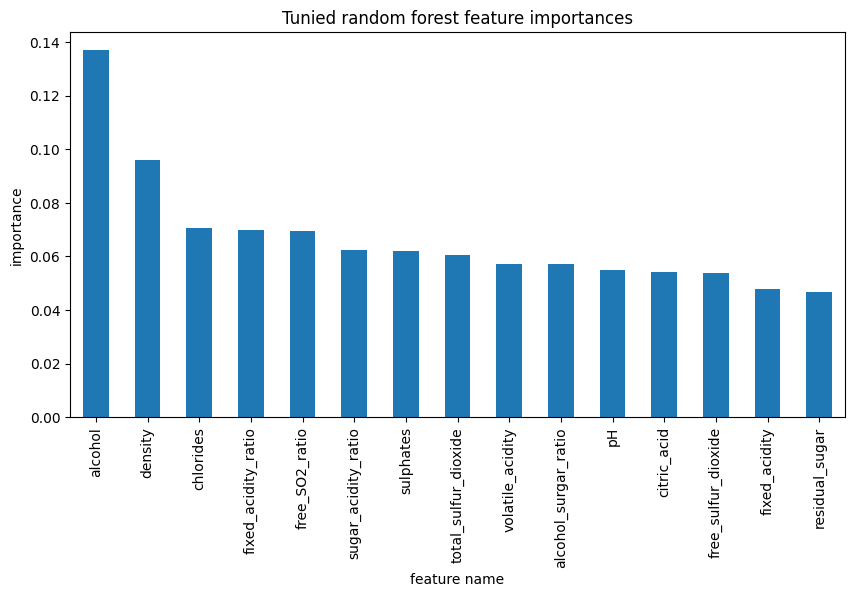

In [48]:
plt.subplots(figsize=(10, 5))
rf_feat = pd.Series(features_imp, index=X_train.columns).sort_values(ascending=False)
rf_feat.plot(kind='bar')
plt.xlabel('feature name')
plt.ylabel('importance')
plt.title('Tunied random forest feature importances');

In [49]:
cv_rf = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='precision', cv=5, n_jobs=-1)

In [50]:
cv_scores_rf = cv_rf['test_score']
np.mean(cv_scores_rf), np.std(cv_scores_rf)

(0.675938714013696, 0.05355589007189242)

In [51]:

y_tr_pred = rf_grid_cv.best_estimator_.predict(X_train)
y_te_pred = rf_grid_cv.best_estimator_.predict(X_test)
y_pred_probs = rf_grid_cv.best_estimator_.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_probs))

0.843435967726703


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


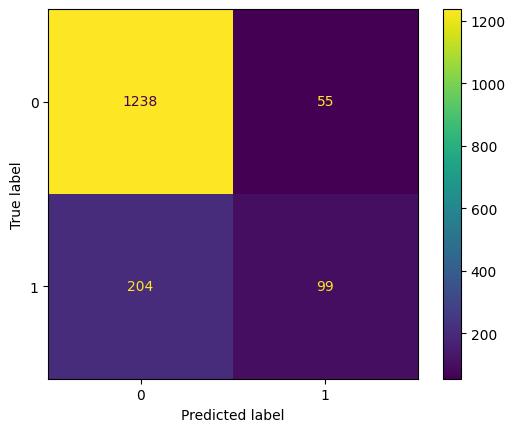

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1293
           1       0.64      0.33      0.43       303

    accuracy                           0.84      1596
   macro avg       0.75      0.64      0.67      1596
weighted avg       0.82      0.84      0.82      1596



In [52]:
report_rf = classification_report(y_test, y_te_pred)
cm_rf = confusion_matrix(y_test, y_te_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_rf,display_labels=rf_grid_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_te_pred))

## Save best model object frome pipeline

In [53]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()


In [54]:
import pickle

In [55]:
# save the model to disk
filename = 'wine_quality_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

## Modeling the wine quality

In [57]:
df= pd.read_csv("../Capstone_Two_Project/data/processed/df_model.csv", index_col = "wine_type_white")
df = df.drop("Unnamed: 0",axis =1)
df


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,free_SO2_ratio,alcohol_surgar_ratio,sugar_acidity_ratio,fixed_acidity_ratio
wine_type_white,,,,,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,32.352941,494.736842,23.456790,91.358025
0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,37.313433,376.923077,29.953917,89.861751
0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,27.777778,426.086957,26.869159,91.121495
0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,28.333333,515.789474,16.550523,97.560976
0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,0,32.500000,522.222222,22.332506,91.811414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0,26.086957,700.000000,24.960998,96.723869
1,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,33.928571,120.000000,115.606936,95.375723
1,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0,27.027027,783.333333,17.804154,96.439169


In [58]:
X=df.drop(["quality"],axis = 1)
y=df["quality"]

In [60]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, y)

0.3092105263157895

## summary

Four modeling were performed in good wine quality prediction. At beginner, the dummyclassifier is used as baseline model, which the prediction is irrelavent to featrues. Then three models logisticregression, random forest model and xgboost were evaluate through pipeline. the cv results shows the random forest model have high precision scores and therefore it be select for further tunning. 